# Homework 7. IASA NLP Course

Made by Andrii Shevtsov

## Imports and constants

In [1]:
!pip install --upgrade umap-learn bertopic python-dotenv openai==0.28 langchain

In [40]:
import os

import re
import io
import string
import random

import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openai

from collections import defaultdict 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from sklearn.base import ClusterMixin, BaseEstimator
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm
from umap import UMAP
from bertopic import BERTopic
from transformers import pipeline
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import OpenAI
from dotenv import load_dotenv

random.seed(155)
np.random.seed(155)
pd.set_option('display.max_colwidth', None)
load_dotenv()

True

In [41]:
INPUT_TEXTS_FILE = "./data/KyivChannels_Dataset_v01.csv"

UKRAINIAN_STOPWORDS_FILE = "./data/stopwords_ua.txt"
TOPICS_FILE = "./data/topics.txt"

In [42]:
openai.api_key = os.getenv('OPENAI_API_KEY')

## Load and preprocess data

In [5]:
df = pd.read_csv(INPUT_TEXTS_FILE)

In [6]:
df.head()

channelname                 Date  \
0  kyivpolitics  2023-08-01 09:45:38   
1  kyivpolitics  2023-08-01 10:03:38   
2  kyivpolitics  2023-08-01 14:42:31   
3  kyivpolitics  2023-08-01 15:37:34   
4  kyivpolitics  2023-08-01 13:06:08   

                                                                                                                                                                                                                                                                                                                                   content  \
0                                                                                                                                                                                                                                                                                 –û—Ç–±–æ–π. –£–≥—Ä–æ–∑—ã –¥–ª—è —Å—Ç–æ–ª–∏—Ü—ã –Ω–µ—Ç\n\n–ö–∏–µ–≤. –ì–ª–∞–≤–Ω–æ–µ. –ü–æ–ª–∏—Ç–∏–∫–∞   
1                       –ù–∞ 8 –ø–µ—Ä–µ–∫—Ä–µ—Å—Ç–∫–∞—Ö –ö–∏–µ–≤–∞ –≤ –ø–∏–ª–æ—Ç–Ω–æ–º —Ä–µ–∂–∏–º–µ –≤–Ω–µ–¥—Ä—è—Ç —Å–º–µ–∂–Ω—É—é —Å–≤–µ—Ç–æ—Ñ–æ—Ä–Ω—É—é —Ä–µ–≥—É–ª–∏—Ä–æ–≤–∫—É –ø–µ—à–µ—Ö–æ–¥–æ–≤ –∏ –≤–µ–ª–æ—Å–∏–ø–µ–¥–∏—Å—Ç–æ–≤\n\n–ù–∞ —ç—Ç–∏—Ö –ø–µ—Ä–µ–∫—Ä–µ—Å—Ç–∫–∞—Ö –¥–æ 1 –Ω–æ—è–±—Ä—è 2023 –±—É–¥—É—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è –∏–∑–º–µ–Ω–µ–Ω–Ω—ã–µ –ª–∏–Ω–∑—ã –ø–µ—à–µ—Ö–æ–¥–Ω—ã—Ö —Å–≤–µ—Ç–æ—Ñ–æ—Ä–æ–≤ —Å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ–º –ø–µ—à–µ—Ö–æ–¥–∞ –∏ –≤–µ–ª–æ—Å–∏–ø–µ–¥–∞.\n\n–°–ø–∏—Å–æ–∫ –ø–µ—Ä–µ–∫—Ä–µ—Å—Ç–∫–æ–≤ –Ω–∞ —Ñ–æ—Ç–æ.\n\n–ö–∏–µ–≤. –ì–ª–∞–≤–Ω–æ–µ. –ü–æ–ª–∏—Ç–∏–∫–∞   
2  ‚ö°Ô∏è–ù–ë–£ –æ—Ç–æ–∑–≤–∞–ª –±–∞–Ω–∫–æ–≤—Å–∫—É—é –ª–∏—Ü–µ–Ω–∑–∏—é –ö–æ–Ω–∫–æ—Ä–¥ –ë–∞–Ω–∫–∞ –∑–∞ –Ω–∞—Ä—É—à–µ–Ω–∏–µ –≤ —Å—Ñ–µ—Ä–µ –¥–µ–Ω–µ–∂–Ω–æ–≥–æ –º–æ–Ω–∏—Ç–æ—Ä–∏–Ω–≥–∞\n\n–†–∞–Ω–µ–µ –æ–Ω —Ñ–∏–≥—É—Ä–∏—Ä–æ–≤–∞–ª –≤ —Ä–∞—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏—è—Ö –ø–æ –º–∏—Å–∫–æ–¥–∏–Ω–≥—É –∏ –º–∞—Ö–∏–Ω–∞—Ü–∏—è–º –∏–≥–æ—Ä–Ω–æ–≥–æ –±–∏–∑–Ω–µ—Å–∞. –í—ã–≤–æ–¥ –µ–≥–æ —Å —Ä—ã–Ω–∫–∞ –Ω–µ –ø–æ–≤–ª–∏—è–µ—Ç –Ω–∞ —Å—Ç–∞–±–∏–ª—å–Ω–æ—Å—Ç—å –±–∞–Ω–∫–æ–≤—Å–∫–æ–≥–æ —Å–µ–∫—Ç–æ—Ä–∞ –£–∫—Ä–∞–∏–Ω—ã. –ö–∞–∂–¥—ã–π –≤–∫–ª–∞–¥—á–∏–∫ –±–∞–Ω–∫–∞ –ø–æ–ª—É—á–∏—Ç –ø–æ–ª–Ω–æ–µ –≤–æ–∑–º–µ—â–µ–Ω–∏–µ.\n\n–ö–∏–µ–≤. –ì–ª–∞–≤–Ω–æ–µ. –ü–æ–ª–∏—Ç–∏–∫–∞   
3                                                                                                                                                                                                                                                       –ó–∞–≤—Ç—Ä–∞ —Å–∏–Ω–æ–ø—Ç–∏–∫–∏ –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä—É—é—Ç –Ω–µ–±–æ–ª—å—à–æ–π –¥–æ–∂–¥—å —Å –≥—Ä–æ–∑–∞–º–∏\n\n–ö–∏–µ–≤. –ì–ª–∞–≤–Ω–æ–µ. –ü–æ–ª–∏—Ç–∏–∫–∞   
4                                                                                                                                                                                                                                                                            –ê –≤–æ—Ç –∏ —Å–∞–º —Å–Ω—è—Ç—ã–π —Å–æ–≤–µ—Ç—Å–∫–∏–π –≥–µ—Ä–± \n\n–ö–∏–µ–≤. –ì–ª–∞–≤–Ω–æ–µ. –ü–æ–ª–∏—Ç–∏–∫–∞   

  lang  
0   ru  
1   ru  
2   ru  
3   ru  
4   ru

Using basic functions from the lecture to clean texts

In [7]:
def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        input = re.sub(r"@\S+", "", input) # Telegram entities deletion
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        input = input.lower()
    return input

df["content_processed"] = df["content"].apply(process_text)

In [8]:
def read_txt_to_list(path, encoding="utf-8"):
    with io.open(path, mode="r", encoding=encoding) as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

nltk.download("stopwords")

ru_stopwords = stopwords.words("russian")
# Taken from https://raw.githubusercontent.com/skupriienko/Ukrainian-Stopwords/master/stopwords_ua.txt 
ua_stopwords = read_txt_to_list(UKRAINIAN_STOPWORDS_FILE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


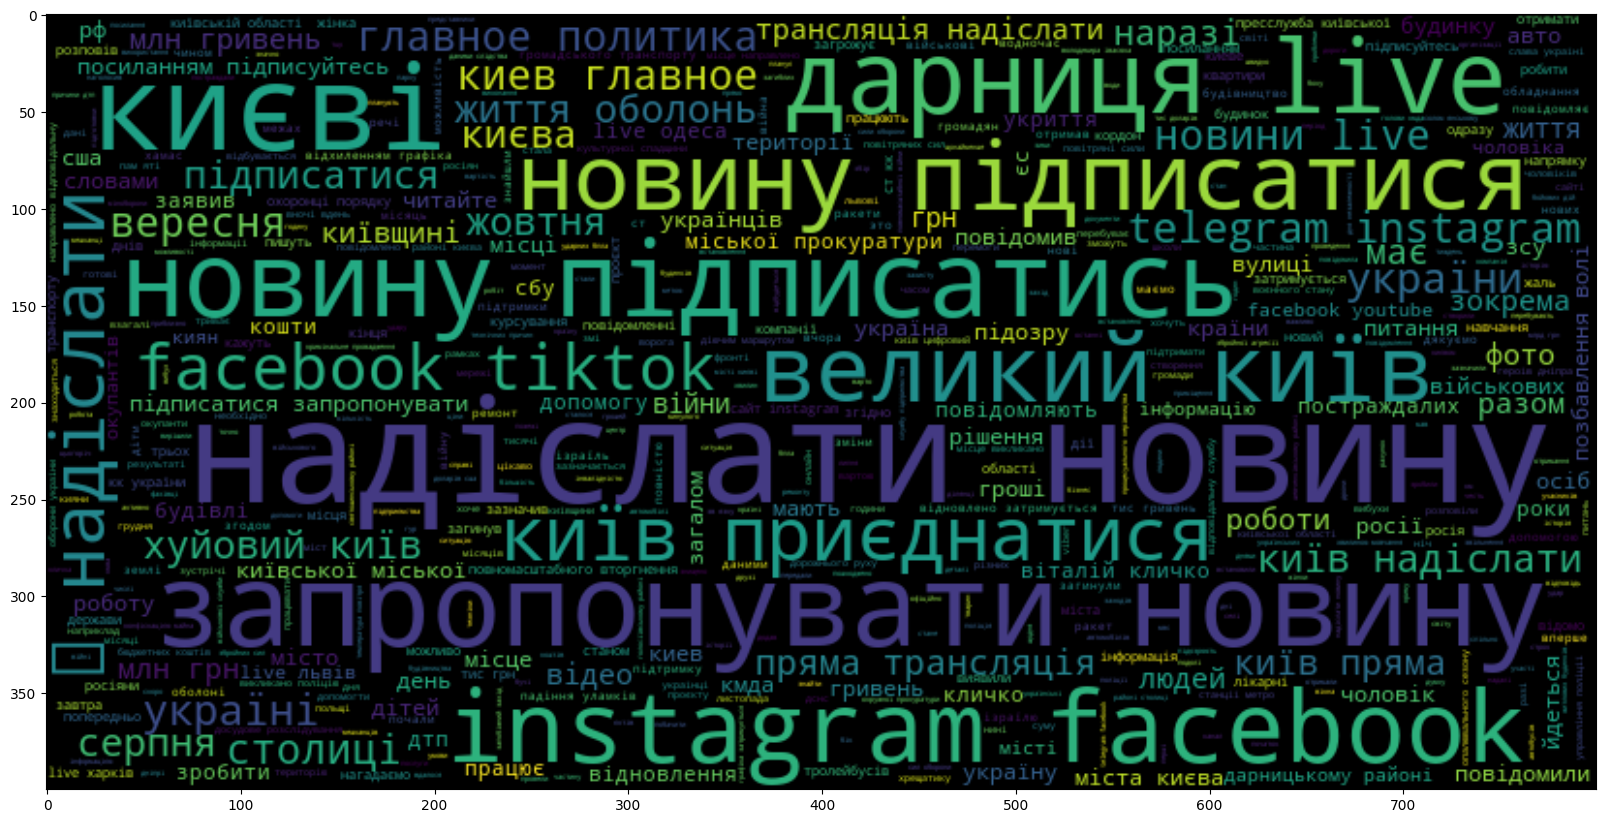

In [9]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(
    max_words = 500, 
    width = 800, 
    height = 400, 
    stopwords = ru_stopwords + ua_stopwords).generate(" ".join(df["content_processed"].apply(lambda x: x.lower())))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

Based on several iterations, I created additional stopwords list:

In [10]:
additional_stopwords = [
    # slogans
    "–Ω–∞–¥—ñ—Å–ª–∞—Ç–∏", "–Ω–æ–≤–∏–Ω—É", "–∑–∞–ø—Ä–æ–ø–æ–Ω—É–≤–∞—Ç–∏", "–ø—Ä–∏—î–¥–Ω–∞—Ç–∏—Å—è", "–ø—ñ–¥–ø–∏—Å–∞—Ç–∏—Å—è", "–ø—ñ–¥–ø–∏—Å–∞—Ç–∏—Å—å", "–ø—Ä—è–º–∞", "—Ç—Ä–∞–Ω—Å–ª—è—Ü—ñ—è", "—á–∏—Ç–∞–π—Ç–µ", "–ø–æ—Å–∏–ª–∞–Ω–Ω—è–º", "–ø—ñ–¥–ø–∏—Å—É–π—Ç–µ—Å—å",
    # Kyiv and Ukraine variations
    "–ö–∏—ó–≤", "–º—ñ—Å—Ç–∞", "–ö–∏—î–≤–∞", "—É–∫—Ä–∞—ó–Ω—Ü—ñ–≤", "–≤–µ–ª–∏–∫–∏–π", "–î–∞—Ä–Ω–∏—Ü—å–∫–æ–º—É —Ä–∞–π–æ–Ω—ñ", "–ö–∏—ó–≤—â–∏–Ω—ñ", "—Å—Ç–æ–ª–∏—Ü—ñ", "–£–∫—Ä–∞—ó–Ω–∞", "–ö–∏—î–≤—ñ", "–ö–∏–µ–≤", "–£–∫—Ä–∞—ó–Ω–∏", "–£–∫—Ä–∞—ó–Ω—ñ", "–æ–±–æ–ª–æ–Ω—å", "–¥–∞—Ä–Ω–∏—Ü—å–∫–æ–º—É", "–£–∫—Ä–∞—ó–Ω—É",
    # channel names
    "–¥–∞—Ä–Ω–∏—Ü—è", "liv–µ", "hmarochos", "—Ö—É–π–æ–≤–∏–π", "–≥–ª–∞–≤–Ω–æ–µ", "–ø–æ–ª–∏—Ç–∏–∫–∞", "novosti_kieva_bot", "–∫–∏–µ–≤", "–≥–ª–∞–≤–Ω–æ–µ", "–∂–∏—Ç—Ç—è –æ–±–æ–ª–æ–Ω—å", "los", "solomas", "–Ω–æ–≤–∏–Ω–∏ live", "–Ω–æ–≤–∏–Ω–∏", "live", "–∂–∏—Ç—Ç—è",
    # social networks
    "telegram", "instagram", "facebook", "tiktok", "youtube", "twitter",
    # untracked real stopwords
    "–Ω–∞—Ä–∞–∑—ñ", "–∑–æ–∫—Ä–µ–º–∞", "–∑–∞–≥–∞–ª–æ–º", "–º–ª–Ω", "–º–∞—î","–≥—Ä–Ω",
    # months
    "–≤–µ—Ä–µ—Å–Ω—è", "–∂–æ–≤—Ç–Ω—è", "—Å–µ—Ä–ø–Ω—è",
    # toponimics
    "–≤—É–ª", "—Ä–∞–π–æ–Ω", "—Ä–∞–π–æ–Ω—ñ"
]

> **TODO**: use some regexps to decrease number of additional stopwords

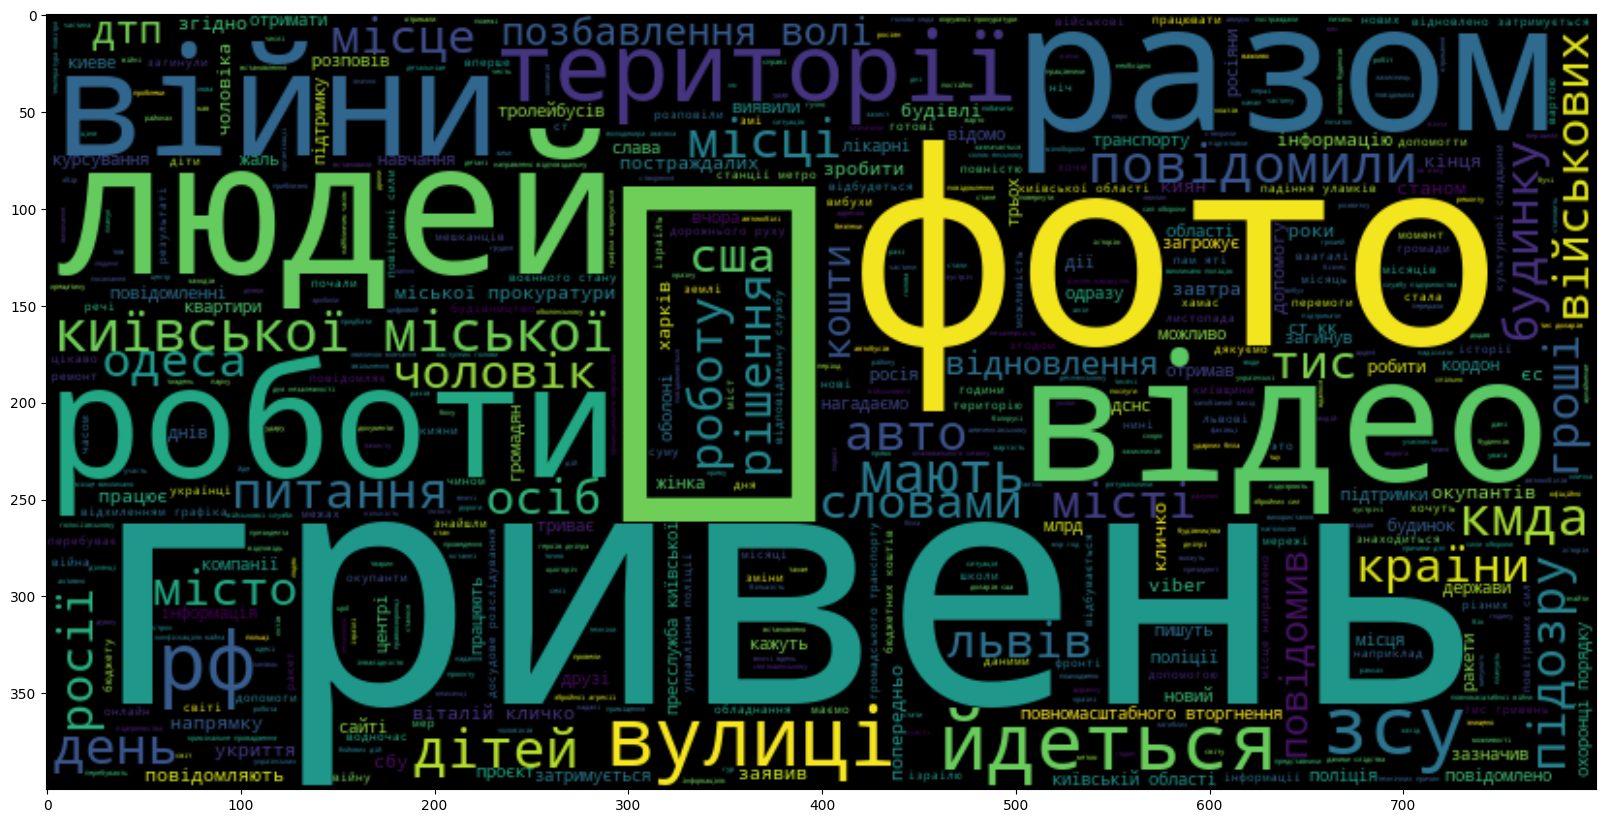

In [11]:
plt.figure(figsize = (20,20)) 
wc2 = WordCloud(
    max_words = 500, 
    width = 800, 
    height = 400,
    stopwords = [word.lower() for word in ru_stopwords + ua_stopwords + additional_stopwords])\
    .generate(" ".join(df["content_processed"]))
plt.imshow(wc2, interpolation = 'bilinear')
plt.show()

In [12]:
stopwords_set = set([word.lower() for word in ru_stopwords + ua_stopwords + additional_stopwords])

df["content_processed_without_stopwords"] = df["content_processed"].apply(wc2.process_text)
df["content_processed"] = df["content_processed"].apply(lambda text: ' '.join([word for word in text.split() if word not in stopwords_set]))

## Part 1. Analyze specific channels

In [13]:
all_channels = df['channelname'].unique()
chosen_channels = np.random.choice(all_channels, 3)
chosen_channels

array(['kyivcityofficial', 'tsum6', 'lisovy_masyv_official'], dtype=object)

In [14]:
# chosen_channels = np.array(['kyivcityofficial', 'tsum6', 'lisovy_masyv_official'])

In [15]:
df_chosen = df[df['channelname'].isin(chosen_channels)]
df_chosen.head()

channelname                 Date  \
27  lisovy_masyv_official  2023-08-01 16:06:57   
28  lisovy_masyv_official  2023-08-01 03:00:09   
29  lisovy_masyv_official  2023-08-01 14:02:05   
30  lisovy_masyv_official  2023-08-01 20:45:31   
33  lisovy_masyv_official  2023-08-01 10:09:25   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   content  \
27                                                                                                                                                                                                                                                                   –ó–∞—Ä–∞–∑ –≤ –Ω—ñ—á–Ω–æ–º—É –Ω–µ–±—ñ —Å—Ç–æ–ª–∏—Ü—ñ –º–æ–∂–Ω–∞ —Å–ø–æ—Å—Ç–µ—Ä—ñ–≥–∞—Ç–∏ ¬´–æ—Å–µ—Ç—Ä–æ–≤–∏–π —Å—É–ø–µ—Ä–º—ñ—Å—è—Ü—å¬ª\n\n–ù–∞—à —Å—É–ø—É—Ç–Ω–∏–∫ –≤–∏–≥–ª—è–¥–∞—î –±—ñ–ª—å—à–∏–º —Ç–∞ —è—Å–∫—Ä–∞–≤—ñ—à–∏–º, –∞–¥–∂–µ –æ–ø–∏–Ω–∏–≤—Å—è –Ω–∞ –≤—ñ–¥—Å—Ç–∞–Ω—ñ 357 530 –∫–º –≤—ñ–¥ –ó–µ–º–ª—ñ (–∑–∞–∑–≤–∏—á–∞–π –ú—ñ—Å—è—Ü—å –∑–Ω–∞—Ö–æ–¥–∏—Ç—å—Å—è –Ω–∞ –≤—ñ–¥—Å—Ç–∞–Ω—ñ –∑ 384 400 –∫–º –≤—ñ–¥ –ø–ª–∞–Ω–µ—Ç–∏).\n\n¬´–û—Å–µ—Ç—Ä–æ–≤–∏–º¬ª –π–æ–≥–æ –ø—Ä–æ–∑–≤–∞–ª–∏ –Ω–∞ —á–µ—Å—Ç—å –Ω–∞–π–±—ñ–ª—å—à–æ—ó —Ä–∏–±–∏ –ü—ñ–≤–Ω—ñ—á–Ω–æ—ó –ê–º–µ—Ä–∏–∫–∏, —è–∫–æ—ó –±–∞–≥–∞—Ç–æ –≤–æ–¥–∏—Ç—å—Å—è –≤ —Ü–µ–π –ø–µ—Ä—ñ–æ–¥ —É —Ç–∞–º—Ç–µ—à–Ω—ñ—Ö –æ–∑–µ—Ä–∞—Ö.\n\n–ü—ñ–¥–ø–∏—Å–∞—Ç–∏—Å—è¬†¬†¬† |¬†¬†¬† –ó–∞–ø—Ä–æ–ø–æ–Ω—É–≤–∞—Ç–∏ –Ω–æ–≤–∏–Ω—É   
28                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    –©–æ—Ä–∞–Ω–∫—É –æ 09:00 –≤—Å—è –£–∫—Ä–∞—ó–Ω–∞ –∑–∞–≤–º–∏—Ä–∞—î - —É —Ü—é –º–∏—Ç—å, –º–∏ –≤—à–∞–Ω–æ–≤—É—î–º–æ –ø–∞–º'—è—Ç—å –∑–∞–≥–∏–±–ª–∏—Ö —É –≤—ñ–π–Ω—ñ —Ö–≤–∏–ª–∏–Ω–æ—é –º–æ–≤—á–∞–Ω–Ω—è\n\n–ü—ñ–¥–ø–∏—Å–∞—Ç–∏—Å—è¬†¬†¬†|¬†¬†¬†–ó–∞–ø—Ä–æ–ø–æ–Ω—É–≤–∞—Ç–∏ –Ω–æ–≤–∏–Ω—É   
29                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      ‚ö†Ô∏è –ü–æ–≤—ñ–¥–æ–º–ª—è—é—Ç—å –ø—Ä–æ –ø–æ–≤—ñ—Ç—Ä—è–Ω—É —Ü—ñ–ª—å, –º–æ–∂–ª–∏–≤–æ —Ñ–∞–ª—å—à —Ü—ñ–ª—å –Ω–∞ –ß–µ—Ä–Ω—ñ–≥—ñ–≤—â–∏–Ω—ñ\n\n–ü—ñ–¥–ø–∏—Å–∞—Ç–∏—Å—è¬†¬†¬† |¬†¬†¬† –ó–∞–ø—Ä–æ–ø–æ–Ω—É–≤–∞—Ç–∏ –Ω–æ–≤–∏–Ω—É   
30                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [16]:
df_chosen['channelname'].value_counts()

channelname
lisovy_masyv_official    722
kyivcityofficial         247
tsum6                     51
Name: count, dtype: int64

### Clustering approaches

The most obvious approach is just to choose all the frequent words for the channel, cluster them and return clusters' most representative words.

Let's try it for the most popular channel in my list:

In [17]:
most_popular = df_chosen['channelname'].value_counts().keys()[0]
most_popular

'lisovy_masyv_official'

In [18]:
df_most_popular = df_chosen[df_chosen['channelname'] == most_popular]

In [19]:
df_most_popular["content_processed_without_stopwords"]

27                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        {'–Ω—ñ—á–Ω–æ–º—É': 1, '–Ω–µ–±—ñ': 1, '—Å–ø–æ—Å—Ç–µ—Ä—ñ–≥–∞—Ç–∏': 1, '–æ—Å–µ—Ç—Ä–æ–≤–∏–π': 1, '—Å—É–ø–µ—Ä–º—ñ—Å—è—Ü—å': 1, '—Å—É–ø—É—Ç–Ω–∏–∫': 1, '–≤–∏–≥–ª—è–¥–∞—î': 1, '–±—ñ–ª—å—à–∏–º': 1, '—è—Å–∫—Ä–∞–≤—ñ—à–∏–º': 1, '–æ–ø–∏–Ω–∏–≤—Å—è': 1, '–≤—ñ–¥—Å—Ç–∞–Ω—ñ': 2, '–∫–º': 2, '–∑–µ–º–ª—ñ': 1, '–º—ñ—Å—è—Ü—å': 1, '–∑–Ω–∞—Ö–æ–¥–∏—Ç—å—Å—è': 1, '–ø–ª–∞–Ω–µ—Ç–∏': 1, '–æ—Å–µ—Ç—Ä–æ–≤–∏–º': 1, '–ø—Ä–æ–∑–≤–∞–

In [20]:
most_popular_ch_words_counts = defaultdict(lambda: 0)
for post_words_counts in df_most_popular["content_processed_without_stopwords"]:
    for word, count in post_words_counts.items():
        most_popular_ch_words_counts[word] += count

In [21]:
sorted(most_popular_ch_words_counts.items(), reverse=True, key=lambda el: el[1])[:20]

[('–∑–∞–≥–∏–±–ª–∏—Ö', 67),
 ('–≤—ñ–π–Ω—ñ', 65),
 ("–ø–∞–º'—è—Ç—å", 63),
 ('–≤—à–∞–Ω–æ–≤—É—î–º–æ', 60),
 ('–º–æ–≤—á–∞–Ω–Ω—è', 60),
 ('—â–æ—Ä–∞–Ω–∫—É', 59),
 ('–∑–∞–≤–º–∏—Ä–∞—î', 59),
 ('–º–∏—Ç—å', 59),
 ('—Ö–≤–∏–ª–∏–Ω–æ—é', 59),
 ('–ª—ñ—Å–æ–≤–∏–π', 53),
 ('–∫—É–±–∞–Ω—Å—å–∫–æ—ó', 43),
 ('—Ä–æ–±–æ—Ç–∏', 42),
 ('–ø–æ–ª—ñ—Ü—ñ—ó', 41),
 ('–≤—É–ª–∏—Ü—ñ', 40),
 ('–ø–æ–ª—ñ—Ü—ñ—è', 35),
 ('–ª—ñ—Å–æ–≤–æ–º—É', 33),
 ('–¥–µ—Å–Ω—è–Ω—Å—å–∫–æ–º—É', 33),
 ('–∫–º–¥–∞', 33),
 ('—á–æ–ª–æ–≤—ñ–∫–∞', 33),
 ('–ª—é–¥–µ–π', 32)]

In [22]:
TOP_P = 0.05

In [23]:
top_words = sorted(most_popular_ch_words_counts.items(), reverse=True, key=lambda el: el[1])

top_words = top_words[:int(TOP_P*len(top_words))]
top_words, _ = zip(*top_words)
top_words[:10]

('–∑–∞–≥–∏–±–ª–∏—Ö',
 '–≤—ñ–π–Ω—ñ',
 "–ø–∞–º'—è—Ç—å",
 '–≤—à–∞–Ω–æ–≤—É—î–º–æ',
 '–º–æ–≤—á–∞–Ω–Ω—è',
 '—â–æ—Ä–∞–Ω–∫—É',
 '–∑–∞–≤–º–∏—Ä–∞—î',
 '–º–∏—Ç—å',
 '—Ö–≤–∏–ª–∏–Ω–æ—é',
 '–ª—ñ—Å–æ–≤–∏–π')

In [24]:
sent_emb_model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2", device="cuda",)

In [25]:
top_words_embeddings = sent_emb_model.encode(top_words, batch_size=100)

In [26]:
top_words_embeddings.shape

(420, 512)

In [27]:
kmeans_clusts_top_words = KMeans(
    n_clusters=10, 
    random_state=155, 
    init="k-means++",
    n_init='auto'
).fit_predict(top_words_embeddings)

In [28]:
top_words_embeddings.shape

(420, 512)

In [29]:
top_words_embeddings[kmeans_clusts_top_words == 0].shape

(5, 512)

In [30]:
topics = []
for cluster_i in np.unique(kmeans_clusts_top_words):
    words = [top_words[i] for i in range(len(top_words)) if kmeans_clusts_top_words[i] == cluster_i]
    embs = top_words_embeddings[kmeans_clusts_top_words == cluster_i]
    
    centroid = np.mean(embs, axis=0)
    lengths = np.linalg.norm(embs - centroid, axis=1)
    min_indices = np.argsort(lengths)
    
    topics.append([words[min_indices[i]] for i in range(min(3, len(words)))])
    
topics

[['—Å–ª—ñ–¥—Å—Ç–≤–∞', '—Ä–æ–∑—Å–ª—ñ–¥—É–≤–∞–Ω–Ω—è', '–ø–µ—Ä–µ–≤—ñ—Ä–∫–∏'],
 ['–∫—ñ–ª—å–∫—ñ—Å—Ç—å', '—Ç—Ä–æ—î—â–∏–Ω–∞', '–¥–µ—Å—è—Ç–∏'],
 ['–ø—Ä–æ–≤–µ–¥–µ–Ω–Ω—è', '–∑–∞—Ö–æ–¥—ñ–≤', '—Å—Ç–∞–Ω–æ–º'],
 ['–º–µ—à–∫–∞–Ω—Ü—ñ–≤', '–æ—Å—ñ–±', '–≤–æ–ª–æ–¥–∏–º–∏—Ä'],
 ['—Ä–∞–π–æ–Ω—É', '—Ä–∞–π–æ–Ω—ñ–≤', '—Ç–µ—Ä–∏—Ç–æ—Ä—ñ—é'],
 ['–≤–¥–µ–Ω—å', '–¥–Ω—è', '–¥–Ω—ñ–≤'],
 ['—Ä–∞–∫–µ—Ç', '—Ä–∞–∫–µ—Ç–∏'],
 ['–¥–æ–ø–æ–º–æ–≥–∞', '–¥–æ–ø–æ–º–æ–≥—É', '–¥–æ–ø–æ–º–æ–≥—Ç–∏'],
 ['–∑–∞–∑–Ω–∞—á–∏–≤', '–≤–æ–ª—ñ', '—Ç—Ä–∏–≤–∞—î'],
 ['–≥—Ä–∏–≤–µ–Ω—å', '—â–µ–ø–ª–µ–Ω–Ω—è', '–ø—ñ–¥–ª—å–æ—Ç—É']]

We can see here, that some lists of words can tell us something while others can't. Often, several several word versions are at the top list. And some themes look very strange, for example, `['–≥—Ä–∏–≤–µ–Ω—å', '—â–µ–ø–ª–µ–Ω–Ω—è', '–ø—ñ–¥–ª—å–æ—Ç—É']`.

Still, let's make a function to create such topic lists and test many hyperparameters and approaches on three channels we have chosen:

In [31]:
def clustering_create_word_topics(
    channel_df: pd.DataFrame,
    clustering_algorithm: ClusterMixin,
    embedder: SentenceTransformer,
    dim_reductor: BaseEstimator = None,
    words_choosing_method: str = "top_p",
    top_p: float = 0.05,
    top_k: int = 100,
    count_bound: int = 10,
    words_topic_out: int = 3
):
    words_choosing_method = words_choosing_method.lower()
    assert words_choosing_method in {"top_p", "top_k", "count_bound", "none"}, "Words choosing method should be one of these"
    
    ch_words_counts = defaultdict(lambda: 0)
    for post_words_counts in channel_df["content_processed_without_stopwords"]:
        for word, count in post_words_counts.items():
            ch_words_counts[word] += count
    
    top_words = sorted(ch_words_counts.items(), reverse=True, key=lambda el: el[1])
    
    if words_choosing_method == 'top_p':
        top_words = top_words[:int(top_p*len(top_words))]
    elif words_choosing_method == 'top_k':
        top_words = top_words[:min(top_k, len(top_words))]
    elif words_choosing_method == 'count_bound':
        _, top_words_counts = zip(*top_words)
        top_words_counts = np.array(top_words_counts)
        top_words = np.array(top_words)[top_words_counts >= count_bound]
    
    top_words, _ = zip(*top_words)
        
    top_words_embeddings = embedder.encode(top_words, batch_size=100)
    
    if dim_reductor:
        top_words_embeddings = dim_reductor.fit_transform(top_words_embeddings)
                
    clusts_top_words = clustering_algorithm.fit_predict(top_words_embeddings)
    
    # if len(clusts_top_words.shape) == 2:
    #     clusts_top_words = np.argmax(clusts_top_words, axis=1)
        
    topics = []
    for cluster_i in np.unique(clusts_top_words):
        if cluster_i < 0: # skipping outliers
            continue
        
        words = [top_words[i] for i in range(len(top_words)) if clusts_top_words[i] == cluster_i]
        embs = top_words_embeddings[clusts_top_words == cluster_i]

        centroid = np.mean(embs, axis=0)
        lengths = np.linalg.norm(embs - centroid, axis=1)
            
        min_indices = np.argsort(lengths)

        topics.append('-'.join([words[min_indices[i]] for i in range(min(words_topic_out, len(words)))]))

    return topics

In [32]:
channel_dfs = [df_chosen[df_chosen['channelname'] == channel_name] for channel_name in chosen_channels]

sets_to_test = {
    'KMeans 5 clusters, no dim reduction, top 5% words': {
        'clustering_algorithm': KMeans(
            n_clusters=5, 
            random_state=155, 
            init="k-means++",
            n_init='auto'
        ),
        'embedder': sent_emb_model,
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'KMeans 5 clusters, no dim reduction, top 1000 words': {
        'clustering_algorithm': KMeans(
            n_clusters=5, 
            random_state=155, 
            init="k-means++",
            n_init='auto'
        ),
        'embedder': sent_emb_model,
        'words_choosing_method': 'top_k',
        'top_k': 1000
    },
    'KMeans 5 clusters, no dim reduction, words with 5+ occurences': {
        'clustering_algorithm': KMeans(
            n_clusters=5, 
            random_state=155, 
            init="k-means++",
            n_init='auto'
        ),
        'embedder': sent_emb_model,
        'words_choosing_method': 'count_bound',
        'count_bound': 5
    },
    'KMeans 5 clusters, no dim reduction, all words': {
        'clustering_algorithm': KMeans(
            n_clusters=5, 
            random_state=155, 
            init="k-means++",
            n_init='auto'
        ),
        'embedder': sent_emb_model,
        'words_choosing_method': 'none'
    },
    'KMeans 5 clusters, PCA 64 components, top 5% words': {
        'clustering_algorithm': KMeans(
            n_clusters=5, 
            random_state=155, 
            init="k-means++",
            n_init='auto'
        ),
        'embedder': sent_emb_model,
        'dim_reductor': PCA(n_components=64, random_state=155),
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'KMeans 5 clusters, t-SNE 3 components, top 5% words': {
        'clustering_algorithm': KMeans(
            n_clusters=5, 
            random_state=155, 
            init="k-means++",
            n_init='auto'
        ),
        'embedder': sent_emb_model,
        'dim_reductor': TSNE(n_components=3, random_state=155),
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'DBSCAN eps 10, 2 min samples, t-SNE 3 components, top 5% words': {
        'clustering_algorithm': DBSCAN(    
            eps=10,
            min_samples=2
        ),
        'embedder': sent_emb_model,
        'dim_reductor': TSNE(n_components=3, random_state=155),
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'DBSCAN eps 0.2, 4 min samples, no dim reduction, top 5% words': {
        'clustering_algorithm': DBSCAN(    
            eps=0.2,
            min_samples=4
        ),
        'embedder': sent_emb_model,
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'DBSCAN eps 0.2, 4 min samples, PCA 64 components, top 5% words': {
        'clustering_algorithm': DBSCAN(    
            eps=0.2,
            min_samples=4
        ),
        'embedder': sent_emb_model,
        'dim_reductor': PCA(n_components=64, random_state=155),
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'DBSCAN eps 0.2, 5 min samples, UMAP 4 components, top 5% words': {
        'clustering_algorithm': DBSCAN(    
            eps=0.2,
            min_samples=5
        ),
        'embedder': sent_emb_model,
        'dim_reductor': UMAP(n_components=4, n_neighbors=15),
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'HDBSCAN min cluster size 5, UMAP 4 components, top 5% words': {
        'clustering_algorithm': HDBSCAN(    
            min_cluster_size=10
        ),
        'embedder': sent_emb_model,
        'dim_reductor': UMAP(n_components=4, n_neighbors=15),
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
}

result_df = pd.DataFrame(index = sets_to_test.keys(), columns = chosen_channels)

for testing_set_name, testing_set in tqdm(sets_to_test.items()):
    for channel_index, channel_name in enumerate(chosen_channels):
        result_df.loc[testing_set_name, channel_name] = clustering_create_word_topics(channel_dfs[channel_index], **testing_set)

result_df

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 11/11 [00:56<00:00,  5.11s/it]


kyivcityofficial  \
KMeans 5 clusters, no dim reduction, top 5% words                                                                                                                                                                                                                                                                                                                 [–∑–∞–∫–ª–∞–¥—ñ–≤-–≤–æ–ª–æ–¥–∏–º–∏—Ä–∞-–º–µ—à–∫–∞–Ω—Ü—ñ–≤, –±—É–¥—ñ–≤–ª—ñ-–±—É–¥—ñ–≤–µ–ª—å-buildings, by-from-over, –∑–∞–∑–Ω–∞—á–∏–≤-–ø—Ä–æ–≤–µ–¥–µ–Ω–Ω—è-–ø—Ä–æ—î–∫—Ç—É, on-to-at]   
KMeans 5 clusters, no dim reduction, top 1000 words                                                                                                                                                                                                                                                                                                        [on-to-at, –ø–æ–¥–∞—á—É-–∑–∞–∑–Ω–∞—á–∏–≤-—è—Å–Ω—é—î, –¥–æ—Ä–æ–∂–Ω—ñ-–¥–æ—Ä–æ–∂–Ω—å–æ–≥–æ-–º–∞—Ä—à—Ä—É—Ç–æ–º, –ø—Ä–æ—î–∫—Ç—É-–ø—Ä–æ—î–∫—Ç-–ø—Ä–∏–¥–±–∞–Ω–Ω—è, –∫—É–ª—å—Ç—É—Ä–∏-–∫—É–ª—å—Ç—É—Ä–Ω–æ—ó-–∫—É–ª—å—Ç—É—Ä—É]   
KMeans 5 clusters, no dim reduction, words with 5+ occurences                                                                                                                                                                                                                                                                                        [–∑–æ–æ–ø–∞—Ä–∫—É-—Ç–≤–∞—Ä–∏–Ω, –ø—Ä–æ—î–∫—Ç—É-–ø—Ä–æ—ó–∑–¥—É-–≥—Ä–∏–≤–µ–Ω—å, –∑–∞–±–µ–∑–ø–µ—á–µ–Ω–Ω—è-–ø—Ä–∏–¥–±–∞–Ω–Ω—è-–ø—Ä–æ—î–∫—Ç, –∑–∞–∑–Ω–∞—á–∏–≤-—ó–∑–¥-–ø—Ä–æ–≤–µ–¥–µ–Ω–Ω—è, —Ü–∏—Ñ—Ä–æ–≤–æ—ó-—Ü–∏—Ñ—Ä–æ–≤–∏–π-digital]   
KMeans 5 clusters, no dim reduction, all words                                                                                                                                                                                                                                                                             [–∑–Ω–æ—à–µ–Ω—É-–≤–µ–∂—ñ-–ø—Ä–æ—ó–∑–Ω–æ–≥–æ, —Å—Ç–æ–ª–∏—á–Ω–∏—Ö-–∑–∞–∫–ª–∞–¥—ñ–≤-–∫–∞–¥—Ä–æ–≤—ñ, –∑–∞–ª—É—á–µ–Ω–æ-–≤—Ç—ñ–ª–∏—Ç–∏-–∑–≤–µ—Ä—Ç–∞—î, –≤—Ç—ñ–ª–µ–Ω–Ω—ñ-–ø—Ä–∏—Å–≤–æ—î–Ω—ñ-–ø—Ä–æ–≤–µ–¥–µ–Ω–∏—Ö, –¥–µ–≥—Ç—è—Ä—ñ–≤—Å—å–∫–æ–≥–æ-—Ö–º–µ–ª—å–Ω–∏—Ü—å–∫–æ–≥–æ-—É–∫—Ä–∞—ó–Ω—Å—å–∫–∏–π]   
KMeans 5 clusters, PCA 64 components, top 5% words                                                                                                                                                                                                                                                                                                              [–ø—Ä–æ—î–∫—Ç—É-–ø—Ä–æ—î–∫—Ç-–∑–∞–∫–ª–∞–¥—ñ–≤, to-at-be, —Ä–µ–º–æ–Ω—Ç-—Ä–µ–º–æ–Ω—Ç–∏-–≤—ñ–¥–Ω–æ–≤–ª–µ–Ω–Ω—è, ukraine-–∫–∏—ó–≤—Å—å–∫–∏–π-–∫–∏—ó–≤—Ä–∞–¥–∞, –∑–∞–∑–Ω–∞—á–∏–≤-—Ç—Ä–∏–≤–∞—î-—á–∏—Å–ª—ñ]   
KMeans 5 clusters, t-SNE 3 components, top 5% words                                                                                                                                                                                                                                                                                                           [–º—ñ—Å—Ç-—Ç—Ä–æ–ª–µ–π–±—É—Å—ñ–≤-—É–ª–∞–º–∫—ñ–≤, was-been-is, –∞–≤—Ç–æ–±—É—Å—ñ–≤-—Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç—ñ-–≥—Ä—É–ø–∏, –¥–µ—Ä–∂–∞–≤–∏-gov-–æ–±–ª–∞–¥–Ω–∞–Ω–Ω—è, –≤–≤–µ—á–µ—Ä—ñ-–º—ñ—Å—å–∫–∞-–º—ñ—Å—å–∫–æ–º—É]   
DBSCAN eps 10, 2 min samples, t-SNE 3 components, top 5% words  [–∑–º—ñ–Ω–∏-–∑–º—ñ–Ω–∞–º–∏, —Ü–∏—Ñ—Ä–æ–≤–∏–π-digital, —Å—Ç–æ–ª–∏—Ü—è-capital, –∫–æ—à—Ç—ñ–≤-–∫–æ—à—Ç–∏, –ø—Ä–∞—Ü—é—î-–ø—Ä–∞—Ü—é—é—Ç—å, have-has, –∑–∞—Ö–∏—Å–Ω–∏–∫–∞–º-–∑–∞—Ö–∏—Å–Ω–∏–∫—ñ–≤, –≤—ñ–π—Å—å–∫–æ–≤–∏—Ö-military, —Å–æ—Ü—ñ–∞–ª—å–Ω–æ—ó-—Å–æ—Ü—ñ–∞–ª—å–Ω–æ, –Ω–µ–æ–±—Ö—ñ–¥–Ω–æ-–Ω–µ–æ–±—Ö—ñ–¥–Ω—ñ, –¥–∏—Ç—è—á–∏—Ö-–¥—ñ—Ç–µ–π, –Ω–∞–≤—á–∞–Ω–Ω—è-–æ—Å–≤—ñ—Ç–∏, –Ω–µ–∑–∞–ª–µ–∂–Ω–æ—Å—Ç—ñ-–Ω–µ–∑–∞–ª–µ–∂–Ω—ñ—Å—Ç—å, –∫—É–ª—å—Ç—É—Ä–∏-–∫—É–ª—å—Ç—É—Ä–Ω–æ—ó, –¥–µ–ø–∞—Ä—Ç–∞–º–µ–Ω—Ç—É-–¥–µ–ø–∞—Ä—Ç–∞–º–µ–Ω—Ç, —Å—ñ–º–µ–π-—Ä–æ–¥–∏–Ω–∏, week-—Ç–∏–∂–¥–µ–Ω—å, 

I created an experiments stand to check different Clustering solutions along with demensionality reduction for topic-by-words clustering. But the main drawback is general approach naiveness, that leads to not-very-accurate results.

Some outcomes I got from the results:
- Top words choosing method does not influence results much, untill we filter infrequent words from the dataset.
- `DBSCAN` highly relies on epsilon and min samples nearby to be a base point, leading to inconsistent results on texts of different lengths.
- `UMAP` works much more accurate then `t-SNE` with this approach.
- I suppose, `DBSCAN` and `HDBSCAN` managed to return better topics than `KMeans`, especially when without dimensionality reduction. But in general, all representations here are messy and hard to analyze.

So, it's time to try...

### Topic Modelling approach

Let's be straightforward and start with `BERTopic`.

In [33]:
topic_model = BERTopic(
    embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
    verbose=True
)

In [34]:
topics, probs = topic_model.fit_transform(df_chosen['content_processed'].to_list())

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2023-11-13 03:20:52,620 - BERTopic - Transformed documents to Embeddings
2023-11-13 03:20:57,423 - BERTopic - Reduced dimensionality
2023-11-13 03:20:57,513 - BERTopic - Clustered reduced embeddings


In [35]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1    271                                  -1_the_of_kyiv_to   
1       0     86           0_–ø–æ–ª—ñ—Ü—ñ—ó_–ø–æ–ª—ñ—Ü–µ–π—Å—å–∫—ñ_—á–æ–ª–æ–≤—ñ–∫–∞_–ø–∞—Ç—Ä—É–ª—å–Ω—ñ   
2       1     61                  1_–º–æ–≤—á–∞–Ω–Ω—è_–∑–∞–≤–º–∏—Ä–∞—î_—Ö–≤–∏–ª–∏–Ω–æ—é_–º–∏—Ç—å   
3       2     58                2_–∫–ª–∏—á–∫–æ_–ø–æ—Å—Ç—Ä–∞–∂–¥–∞–ª–∏—Ö_–Ω–µ–º–∞—î_—É–ª–∞–º–∫—ñ–≤   
4       3     57                        3_—Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç—É_–≤—É–ª_—Ä—É—Ö—É_–∑–º—ñ–Ω–∏   
5       4     44               4_—Ü–∏—Ñ—Ä–æ–≤–∏–π_–∑–∞—Å—Ç–æ—Å—É–Ω–∫—É_–∫–∞—Ä—Ç–∫–æ—é_–ø—Ä–æ—ó–∑–¥   
6       5     31                             5_–∞–≤—Ç–æ_–¥—Ç–ø_–∂–∏–≤–∏–π_–∑–±–∏–ª–∏   
7       6     30                           6_00_–º—É–∑–µ—ó_—ñ—Å—Ç–æ—Ä—ñ—é_–º—É–∑–µ–π   
8       7     29  7_—Å–∞–ø–µ—Ä–∏_–≥—É—á–Ω–æ_–ª—ñ–∫–≤—ñ–¥–æ–≤—É–≤–∞—Ç–∏–º—É—Ç—å_–≤–∏–±—É—Ö–æ–Ω–µ–±–µ–∑–ø–µ—á–Ω—ñ   
9       8     28           8_—É–∫—Ä–∞—ó–Ω–∏_–Ω–µ–∑–∞–ª–µ–∂–Ω–æ—Å—Ç—ñ_–¥–µ–Ω—å_–Ω–µ–∑–∞–ª–µ–∂–Ω—ñ—Å—Ç—å   
10      9     27                   9_–∫–ª–∏—á–∫–∞_–ø–∞—Ä–∫—ñ–≤_—Ä—ñ—à–µ–Ω–Ω—è_–∫–∏—ó–≤—Ä–∞–¥–∏   
11     10     26                    10_—Ç–µ–º–ø–µ—Ä–∞—Ç—É—Ä–∞_–≤–¥–µ–Ω—å_–¥–æ—â_–æ–ø–∞–¥—ñ–≤   
12     11     25            11_–∑–∏–º–∏_—Å–µ–∑–æ–Ω—É_–æ–ø–∞–ª—é–≤–∞–ª—å–Ω–æ–≥–æ_–æ–±–ª–∞–¥–Ω–∞–Ω–Ω—è   
13     12     25                   12_–º–∞—Å–∏–≤_–ª—ñ—Å–æ–≤–∏–π_–ª—ñ—Å–æ–≤–æ–º—É_–º–∞—Å–∏–≤—ñ   
14     13     23               13_–∑–∞–º—ñ–Ω—É–≤–∞–Ω–Ω—è_—à–∫—ñ–ª_–ø–æ–ª—ñ—Ü—ñ—è_—Å–µ—Ä–µ–¥–Ω—ñ—Ö   
15     14     21               14_–¥–æ–ø–æ–º–æ–≥—É_–Ω—ñ–º–µ—á—á–∏–Ω–∏_–≤—ñ—Ç–∞–ª—ñ–π_–∫–ª–∏—á–∫–æ   
16     15     21                     15_—Ç–≤–∞—Ä–∏–Ω_—Ç–≤–∞—Ä–∏–Ω–∏_—Å–∫–∞–∑—É_—Å–æ–±–∞–∫–∏   
17     16     20                       16_—Ä—Ñ_–±—ñ–ª–æ—Ä—É—Å—ñ_—Ä–∞–∫–µ—Ç_—Ä–æ—Å—ñ—è–Ω–∏   
18     17     20                            17_—Ç—É_95–º—Å_—Ä–∞–∫–µ—Ç_–±–æ—Ä—Ç—ñ–≤   
19     18     19                18_–≤—É–ª_–∫—É–±–∞–Ω—Å—å–∫–æ—ó_–º—ñ–ª—é—Ç–µ–Ω–∫–∞_—è—Ä–º–∞—Ä–∫–∏   
20     19     19                          19_–≤—É—Ö–∞_–∑–Ω–∞—é_–±–µ—Ä–µ–≥_–ø—Ä–∏–≤—ñ—Ç   
21     20     14                 20_—Ç–µ–ø–ª–∞_–∑–∞—è–≤–∫–∞–º–∏_—Å–æ—Ü—ñ–∞–ª—å–Ω–æ—ó_—Å—Ñ–µ—Ä–∏   
22     21     14                         21_–æ—Å–≤—ñ—Ç–∏_–Ω–∞–≤—á–∞–Ω–Ω—è_—Ä–æ–∫—É_to   
23     22     14                    22_30_–∫–∏—ó–≤–∑–æ–æ_–∑–æ–æ–ø–∞—Ä–∫—É_–ø–æ–∫–∞–∑–æ–≤—ñ   
24     23     13                                   23_77_62_063_150   
25     24     12            24_–±—é–¥–∂–µ—Ç—É_–º—ñ–ª—å—è—Ä–¥–∏_–∫–∏—ó–≤—Ä–∞–¥–∏_–∑–∞—Ö–∏—Å–Ω–∏–∫–∞–º   
26     25     12              25_–æ–≥–æ–ª–æ—à–µ–Ω–Ω—è_–∑–≤–µ—Ä—Ç–∞–π—Ç–µ—Å—è_–ª—ñ—Å–æ–≤–æ–º—É_08   

                                                                                                          Representation  \
0                                                                      [the, of, kyiv, to, in, and, 00, —Ä–æ–±–æ—Ç–∏, for, on]   
1         [–ø–æ–ª—ñ—Ü—ñ—ó, –ø–æ–ª—ñ—Ü–µ–π—Å—å–∫—ñ, —á–æ–ª–æ–≤—ñ–∫–∞, –ø–∞—Ç—Ä—É–ª—å–Ω—ñ, –ø—Ä–∞–≤–æ–æ—Ö–æ—Ä–æ–Ω—Ü—ñ, –∑–∞—Ç—Ä–∏–º–∞–ª–∏, –ø–æ–ª—ñ—Ü—ñ—è, –≤–∏—è–≤–∏–ª–∏, –¥–µ—Å–Ω—è–Ω—Å—å–∫–æ–º—É, —á–æ–ª–æ–≤—ñ–∫]   
2                                    [–º–æ–≤—á–∞–Ω–Ω—è, –∑–∞–≤–º–∏—Ä–∞—î, —Ö–≤–∏–ª–∏–Ω–æ—é, –º–∏—Ç—å, —â–æ—Ä–∞–Ω–∫—É, –≤—à–∞–Ω–æ–≤—É—î–º–æ, –≤—ñ–π–Ω—ñ, —è—Ç—å, 09, –∑–∞–≥–∏–±–ª–∏—Ö]   
3                      [–∫–ª–∏—á–∫–æ, –ø–æ—Å—Ç—Ä–∞–∂–¥–∞–ª–∏—Ö, –Ω–µ–º–∞—î, —É–ª–∞–º–∫—ñ–≤, –≤—ñ—Ç–∞–ª—ñ–π, —Ä–∞–π–æ–Ω—ñ, —Å–ª—É–∂–±–∏, –ø–∞–¥—ñ–Ω–Ω—è, —à–µ–≤—á–µ–Ω–∫—ñ–≤—Å—å–∫–æ–º—É, –ø–æ–∂–µ–∂—É]   
4                   [—Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç—É, –≤—É–ª, —Ä—É—Ö—É, –∑–º—ñ–Ω–∏, –≥—Ä–æ–º–∞–¥—Å—å–∫–æ–≥–æ, —ñ–Ω—Ñ–æ—Ä–º—É—î–º–æ, –Ω–∞–π–±–ª–∏–∂—á—ñ, –¥–æ—Ä–æ–∂–Ω—å–æ–≥–æ, –æ—Ä–≥–∞–Ω—ñ–∑–∞—Ü—ñ—ó, —Ä–æ–±–æ—Ç—ñ]   
5                            [—Ü–∏—Ñ—Ä–æ–≤–∏–π, –∑–∞—Å—Ç–æ—Å—É–Ω–∫—É, –∫–∞—Ä—Ç–∫–æ—é, –ø—Ä–æ—ó–∑–¥, –º–µ—Ç—Ä–æ, –±–∞–Ω–∫—ñ–≤—Å—å–∫–æ—é, –æ–ø–ª–∞—Ç–∏, –æ–ø–∏—Ç—É–≤–∞–Ω–Ω—è, –∫–∞—Ä—Ç–∫–∏, qr]   
6                                          [–∞–≤—Ç–æ, –¥—Ç–ø, –∂–∏–≤–∏–π, –∑–±–∏–ª–∏, –∞–≤–∞—Ä

In [36]:
topic_model.get_topic(3)

[('—Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç—É', 0.07956516312397884),
 ('–≤—É–ª', 0.06767731287150584),
 ('—Ä—É—Ö—É', 0.06614000549467232),
 ('–∑–º—ñ–Ω–∏', 0.06139860695588249),
 ('–≥—Ä–æ–º–∞–¥—Å—å–∫–æ–≥–æ', 0.05771638018042547),
 ('—ñ–Ω—Ñ–æ—Ä–º—É—î–º–æ', 0.0572455081606378),
 ('–Ω–∞–π–±–ª–∏–∂—á—ñ', 0.056836389816513275),
 ('–¥–æ—Ä–æ–∂–Ω—å–æ–≥–æ', 0.054494117133250156),
 ('–æ—Ä–≥–∞–Ω—ñ–∑–∞—Ü—ñ—ó', 0.054127300446565794),
 ('—Ä–æ–±–æ—Ç—ñ', 0.048416532616908065)]

In [37]:
def bertopic_create_word_topics(
    channel_df: pd.DataFrame,
    topic_model: BERTopic,
    words_topic_out: int = 3
):
    topics, probs = topic_model.fit_transform(channel_df['content_processed'].to_list())
        
    topics_res = []
    topics_info = topic_model.get_topic_info()
    for topic_i in range(len(topics_info)):
        if topics_info.loc[topic_i, 'Topic'] < 0: # skipping outliers
            continue
        
        if topic_model.get_topic(topic_i):
            this_topic_words, _ = zip(*topic_model.get_topic(topic_i))

            topics_res.append('-'.join([this_topic_words[i] for i in range(min(words_topic_out, len(this_topic_words)))]))

    return topics_res

In [46]:
openai_prompt = """I have a topic that contains the following documents: 
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format, up to 3 words:
topic: <topic label>
"""

representation_model = OpenAI(model="gpt-3.5-turbo", chat=True, prompt=openai_prompt, nr_docs=4, delay_in_seconds=10)

In [ ]:
channel_dfs = [df_chosen[df_chosen['channelname'] == channel_name] for channel_name in chosen_channels]

sets_to_test = {
    'Distiluse emb, rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            verbose=False
        ),
    },
    'Distiluse emb, UMAP 10 comps, rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            verbose=False
        ),
    },
    'XLM Roberta emb, UMAP 10 comps, rest default': {
        'topic_model': BERTopic(
            embedding_model=pipeline("feature-extraction", model="xlm-roberta-base"),
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            verbose=False
        ),
    },
    'Distiluse emb, PCA 16 comps, rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = PCA(n_components=16, random_state=155),
            verbose=False
        ),
    },
    'Distiluse emb, UMAP 10 comps, HDBSCAN 15 cluster size rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            hdbscan_model = HDBSCAN(min_cluster_size=15),
            verbose=False
        ),
    },
    'Distiluse emb, UMAP 10 comps, HDBSCAN 15 cluster size rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            hdbscan_model = KMeans(n_clusters=20),
            verbose=False
        ),
    },
    'Distiluse emb, UMAP 10 comps, HDBSCAN 15 cluster size, c-TF-IDF reduces frequent words, rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            hdbscan_model = HDBSCAN(min_cluster_size=15),
            ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True),
            verbose=False
        ),
    },
    'Distiluse emb, UMAP 10 comps, HDBSCAN 15 cluster size, c-TF-IDF + bm25, rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            hdbscan_model = HDBSCAN(min_cluster_size=15),
            ctfidf_model = ClassTfidfTransformer(bm25_weighting=True),
            verbose=False
        ),
    },
    'Distiluse emb, UMAP 10 comps, HDBSCAN 15 cluster size, c-TF-IDF + bm25, GPT-3.5 rep': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            hdbscan_model = HDBSCAN(min_cluster_size=15),
            ctfidf_model = ClassTfidfTransformer(bm25_weighting=True),
            representation_model=representation_model,
            verbose=False
        ),
    },
}

result_df = pd.DataFrame(index = sets_to_test.keys(), columns = chosen_channels)

for testing_set_name, testing_set in tqdm(sets_to_test.items()):
    for channel_index, channel_name in enumerate(chosen_channels):
        result_df.loc[testing_set_name, channel_name] = bertopic_create_word_topics(channel_dfs[channel_index], **testing_set)

result_df

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
  0%|                                                                                            | 0/8 [00:00<?, ?it/s]2023-11-13 04:00:11,872 - BERTopic - Transforme

Topic modeling outcomes are:
- 
- `OpenAI` representation tuning works (but not very reliable, for example 403 error can easily occur). On the one hand, it makes more understandable topic representations, and on the other, sometimes it decreases accuracy dramatically.

## Part 2. Universal approach and applying it to the whole dataset

Universal approach I came up with is rather simple: we use BERTopic to find topics of the corpora. At the same time we have a fixed set of topics to use. Then we use 1 nearest neighbour to assign a fixed topic (or several of them) to each newly created. LLM can be used here as well, but the result is not very reliable in that case.

Let's perform this approach on the whole dataset with the best BERTopic setup from the previous task:

In [ ]:
topic_model = BERTopic(
    embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
    verbose=True
)

In [ ]:
topics, probs = topic_model.fit_transform(df['content_processed'].to_list())

In [ ]:
stable_topics = read_txt_to_list(TOPICS_FILE)

In [ ]:
embedder = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2", device="cuda",)

In [ ]:
stable_topics_embedded = embedder.encode(stable_topics, batch_size=100)

In [ ]:
topic_info = topic_model.get_topic_info()
for topic_i, topic_data in enumerate(topic_info):
    if topic_data['Topic'] == -1:
        continue
    
    topic_representation = ' '.join(topic_data['Representation'])
    topic_representation_embedded = embedder.encode(topic_representation, batch_size=100)
    
    lengths = np.linalg.norm(stable_topics_embedded - topic_representation_embedded, axis=1)
    
    topics_sorted = np.argsort(lengths)
    
    topic_info.loc[topic_i, 'Stable topic'] = stable_topics[topics_sorted[0]]

In [ ]:
channels_topics_matrix = pd.DataFrame(index=df['channelname'].unique(), columns=stable_topics, value=0)

for channelname, topic in zip(df['channelname'], topics):
    stable_topic = topic_info.loc[topic_info['Topic'] == topic, 'Stable topic']
    
    channels_topics_matrix.loc[channelname, stable_topic] += 1

In [ ]:
topics_return = 3

for channelname in df['channelname'].unique():
    if channels_topics_matrix.loc[channelname].sum() == 0:
        continue
        
    topics_counts = channels_topics_matrix.loc[channelname]
    topics_counts_ord = np.argsort(topics_counts)
    
    print(channelname, '->', [stable_topics[topics_counts_ord[-i-1]] for i in range(topics_return)])